<a href="https://colab.research.google.com/github/celinexuclover/Rajprojects/blob/master/Copy_of_neural_style_audio_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install librosa

In [0]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Cloning into 'neural-style-audio-tf'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26
Unpacking objects: 100% (26/26), done.


In [19]:
%cd neural-style-audio-tf

/content/neural-style-audio-tf/neural-style-audio-tf


In [20]:
%ls

inputs/  neural-style-audio-tf.ipynb  outputs/  README.md


In [11]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: wrapt, tensorflow-estimator, gast, numpy, google-pasta, opt-einsum, astor, six, keras-applications, grpcio, protobuf, wheel, termcolor, tensorboard, absl-py, keras-preprocessing
Required-by: stable-baselines, magenta, fancyimpute


In [7]:
#!wget http://website.com/song.mp3

--2019-11-07 10:24:58--  http://website.com/song.mp3
Resolving website.com (website.com)... 65.61.198.201
Connecting to website.com (website.com)|65.61.198.201|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.website.com/song.mp3 [following]
--2019-11-07 10:24:58--  https://www.website.com/song.mp3
Resolving www.website.com (www.website.com)... 65.61.198.201
Connecting to www.website.com (www.website.com)|65.61.198.201|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2019-11-07 10:24:59 ERROR 404: Not Found.



### Load style and content

In [0]:
STYLE_FILENAME = "neural-style-audio-tf/inputs/usa.mp3"
CONTENT_FILENAME = "neural-style-audio-tf/inputs/eminem.mp3"

#CONTENT_FILENAME = "In The End (Official Video) - Linkin Park-eVTXPUF4Oz4.webm"
#STYLE_FILENAME = "REEPS ONE x LONDON CONTEMPORARY VOICES  - 'YOUR TONE' LIVE AT UNION CHAPEL LONDON WITH 150 VOICES-s7BhHhYvwyQ.webm"


In [26]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

ValueError: ignored

In [0]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:]))  
    return S, fs

In [28]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]

a_style = a_style[:N_CHANNELS, :N_SAMPLES]

FileNotFoundError: ignored

this use for if choosing radom sound from youtube, but not need to be used 
if use the defualt sound


In [0]:
print(a_content.shape)
print(a_style.shape)

(1025, 9374)
(1025, 10489)


In [0]:
a_content = a_content[:,0:400]
a_style = a_style[:,600:1000]


In [0]:
print(a_content.shape)
print(a_style.shape)

(1025, 400)
(1025, 400)


### Visualize spectrograms for content and style tracks

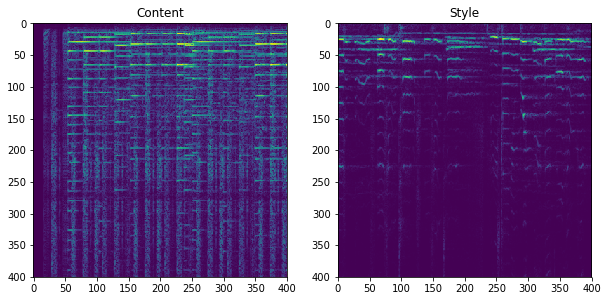

In [0]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [0]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

### Optimize

In [0]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 430.199615
  Number of iterations: 300
  Number of functions evaluations: 308
Final loss: 430.19962


### Invert spectrogram and save the result

In [0]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'reeps_linkinpark.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [0]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

reeps_linkinpark.wav


### Visualize spectrograms

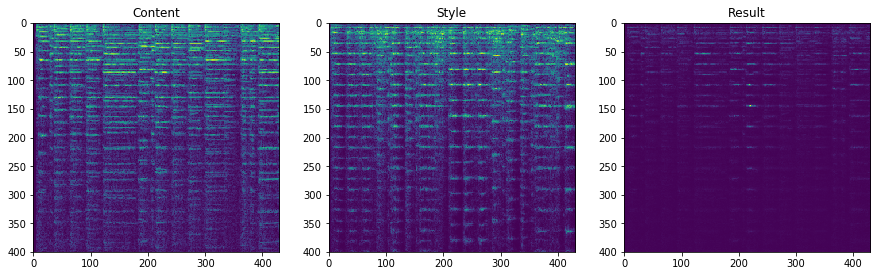

In [0]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()

In [0]:
!pip install youtube-dl

     |████████████████████████████████| 1.8MB 2.8MB/s 


In [0]:
!youtube-dl -f bestaudio https://www.youtube.com/watch?v=eVTXPUF4Oz4

[youtube] eVTXPUF4Oz4: Downloading webpage
[youtube] eVTXPUF4Oz4: Downloading video info webpage
[youtube] eVTXPUF4Oz4: Downloading js player vfl9U3JY7
[youtube] eVTXPUF4Oz4: Downloading js player vfl9U3JY7
[download] Destination: In The End (Official Video) - Linkin Park-eVTXPUF4Oz4.webm
[download] 100% of 3.36MiB in 00:00


In [0]:
!ls

'In The End (Official Video) - Linkin Park-eVTXPUF4Oz4.webm'   out.wav
 neural-style-audio-tf					       sample_data


In [0]:
f = "In The End (Official Video) - Linkin Park-eVTXPUF4Oz4.webm"
f2 = "REEPS ONE x LONDON CONTEMPORARY VOICES  - 'YOUR TONE' LIVE AT UNION CHAPEL LONDON WITH 150 VOICES-s7BhHhYvwyQ.webm"


(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 22050)

In [0]:
!youtube-dl -f bestaudio https://www.youtube.com/watch?v=s7BhHhYvwyQ

[youtube] s7BhHhYvwyQ: Downloading webpage
[youtube] s7BhHhYvwyQ: Downloading video info webpage
[download] Destination: REEPS ONE x LONDON CONTEMPORARY VOICES  - 'YOUR TONE' LIVE AT UNION CHAPEL LONDON WITH 150 VOICES-s7BhHhYvwyQ.webm
[download] 100% of 3.69MiB in 00:00
